In [11]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn, gamma
from scipy.misc import derivative
from scipy.integrate import nquad
import camb
from camb import model, initialpower

In [12]:
zmin,zmax = 0.16, 0.36
zcenter,dndz = load('dndz_lowz.npy')
pz = interpolate.interp1d(zcenter,dndz,bounds_error=0,fill_value=0.)

## growth D(a)
zarr1=linspace(0,1,1001)
az = lambda z: 1.0/(1.0+z)
za = lambda a: 1.0/a-1
D_fcn = lambda a: H(za(a))/H0 * quad(lambda a: (om/a+ol*a**2)**(-1.5), 0, a)[0]
D1 = D_fcn(1)
D_arr = array([D_fcn (az(iz)) for iz in zarr1])/D1

###### logrithmic growth f=dln(D)/dln(a)
###### first do dD/da then x a/D
dnda_arr = array([derivative(D_fcn, az(iz), dx=1e-5) for iz in zarr1])
f_arr = az(zarr1)/D_arr * dnda_arr

Dinterp = interpolate.interp1d(zarr1,D_arr,bounds_error=0,fill_value=0.)
finterp = interpolate.interp1d(zarr1,f_arr,bounds_error=0,fill_value=0.)
betaD = lambda z: finterp(z)/bD

In [13]:
### constants
c = 299792.458#km/s
Gnewton = 6.674e-8#cgs cm^3/g/s^2

## cosmology WMAP9
h = 0.7
H0 = h*100
oc = 0.236
ob = 0.046
om = ob+oc
ol = 1-om#0.718
ns = 0.9646
s8 = 0.817

## IA related constants
C1rhoc = 0.0134 #C1*rho_crit
bD = 1.77 #LOWZ measurement
Ai=4.6
const = Ai*bD*C1rhoc*om/2.0/pi**2

## small functions
H = lambda z: H0*sqrt(om*(1+z)**3+ol)
H_inv = lambda z:  1/(H0*sqrt(om*(1+z)**3+ol))
Hcgs = lambda z: H(z)*3.24e-20
DC = lambda z: c*quad(H_inv, 0, z)[0]
W_fcn = lambda z: (pz(z) / DC(z))**2 / c * H(z) # dchi/dz = c/H
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton

Wnorm = quad(W_fcn, zmin, zmax) [0]
W_arr = array([W_fcn(iz)/Wnorm for iz in zarr])
W = interpolate.interp1d(zarr,W_arr,bounds_error=0,fill_value=0.)

In [14]:
data_mean = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,5].reshape(25,-1).T
rp_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,0].reshape(25,-1).T
pi_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,1].reshape(25,-1).T

## make a reflection for negative r 
data_mean2=concatenate([data_mean,data_mean])
rp_bins2=concatenate([rp_bins,-rp_bins])
pi_bins2=concatenate([pi_bins,pi_bins])

icolors=['yellow','cyan','red','blue','mediumpurple']
icolors_deep=['darkorange','deepskyblue','maroon','midnightblue','purple']
bounds=logspace(-3,0,6)

In [15]:
### power spectrum from camb, takes long time
Nz = 21
zarr = linspace(zmin, zmax, Nz)
pars = camb.CAMBparams()
pars.set_cosmology(H0=70, ombh2=ob*h**2, omch2=om*h**2)#omch2=oc*h**2)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=zarr, kmax=100.0)
results = camb.get_results(pars)
########### NL power spectrum ########
pars.NonLinear = model.NonLinear_both
#pars.NonLinear = model.NonLinear_none  #linear
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100.0, npoints = 150)

Note: redshifts have been re-sorted (earliest first)


In [16]:
########## marko functions, prepare the frequencies at different redshifts
Nk = len(kh_nonlin)
klogstep = log(kh_nonlin[1]/kh_nonlin[0])
kmin,kmax=kh_nonlin[[0,-1]]
ifreq = fftfreq(Nk)##
nu = 1j*2*pi*fftfreq(Nk, d=klogstep) ## the argument goes into k^nu_n, now nu_n is nu_arr
betaD_arr = [betaD(iz) for iz in z_nonlin] 

def cn_fun (i):#i is the redshift counter
    kPk = pk_nonlin[i]*kh_nonlin
    kPk_fft = fft(kPk) ## FFT
    cn = kPk_fft*kmin**(-nu) 
    return cn
cn_arr = array(map(cn_fun, arange(Nz))).reshape(21,1,1,150)
print cn_arr.shape, rp_bins2.shape, pi_bins2.shape

(21, 1, 1, 150) (40, 25) (40, 25)


In [17]:
########## now compare how accurate marko's integration is
# this one is for test, without RSD term
# Fcoeff = lambda rp, PI, nu: rp**2/(rp**2+PI**2)**(2.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)/(1-nu**2)
# full term
Nr = 201
rppitheo = linspace(-60,60,Nr)
rptheo, pitheo = meshgrid(rppitheo, rppitheo)
idz = zarr[1]-zarr[2]
Fcoeff = lambda rp, PI, betaD: rp**2/(rp**2+PI**2)**(3.0+nu/2.0)*cos(pi*nu/2.0)*gamma(3.0+nu)*( (nu-3.0)*(rp**2+PI**2)+ (rp**2-(3+nu)*PI**2*betaD))/(nu-3.0)/(nu**2-1)
xi_int = lambda i: sum(W(zarr[i])/Dinterp(zarr[i])*cn_arr[i]*Fcoeff(rptheo.reshape(Nr,Nr,1), pitheo.reshape(Nr,Nr,1), 
                                                betaD_arr[i]), axis=-1)/Nk*idz

In [20]:
#### integrate over the redshift kernel
#### 1.4*const is for isophotal (used in fig.10)
#### isophotal shapes give you 40% higher Ai than re-Gaussian shapes (re-Gaussian gives Ai=4.6)
xi_all = 1.4*const*sum(array(map(xi_int, range(Nz))), axis=0)

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in power
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


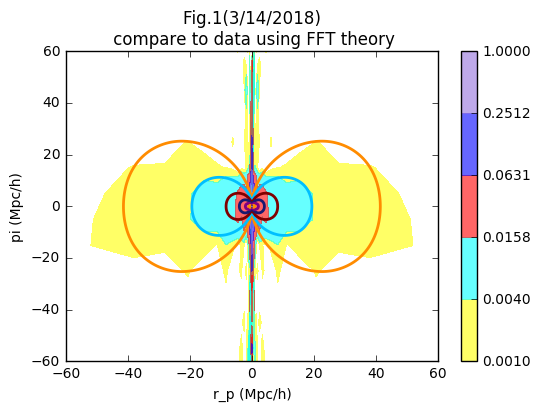

In [23]:
f, ax=subplots(1,1, figsize=(6,4))
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors,alpha=0.6)
ax.set_ylim(-60,60)
CS2=ax.contour(rptheo, pitheo, xi_all, bounds,colors=icolors_deep,linewidths=2,alpha=1)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.1(3/14/2018)\n compare to data using FFT theory')
show()

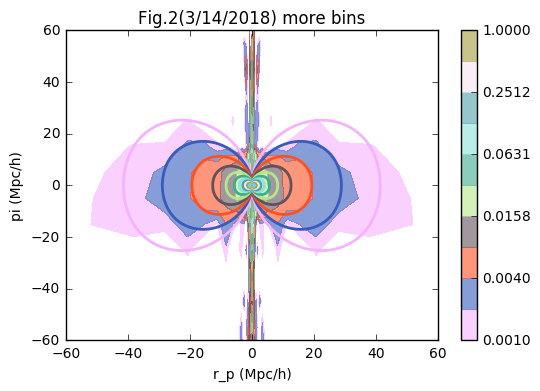

In [22]:
bounds2 = logspace(-3,0,11)
seed(24)
ic2=rand(15,3)
f, ax=subplots(1,1, figsize=(6,4))
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds2,colors=ic2,alpha=0.6)
ax.set_ylim(-60,60)
CS2=ax.contour(rptheo, pitheo, xi_all, bounds2,colors=ic2,linewidths=2,alpha=1)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.2(3/14/2018) more bins')
show()

In [26]:
########### get error bar ########
# data_mean = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,5].reshape(25,-1).T
# rp_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,0].reshape(25,-1).T
# pi_bins = loadtxt('lowz/fulle_bins2D_cross_final.dat')[:,1].reshape(25,-1).T
########## low z data jacknife
data_jk = array([loadtxt('lowz/fulle_bins2D_cross_jk%i_final.dat'%i)[:,5].reshape(25,-1).T for i in range(100)])
print data_jk.shape, rp_bins.shape, pi_bins.shape

(100, 20, 25) (20, 25) (20, 25)


In [191]:
############## here calculate theory value at each point
xi_int_lowzbin = lambda i: sum(W(zarr[i])/Dinterp(zarr[i])*cn_arr[i]*Fcoeff(rp_raw.reshape(-1,1), pi_raw.reshape(-1,1), 
                                                betaD_arr[i]), axis=-1)/Nk*idz
xi_lowzbin = const/Ai*sum(array(map(xi_int_lowzbin, range(Nz))), axis=0)
xi_lowzbin = real(xi_lowzbin.flatten())
print xi_lowzbin.shape

(500,)


300


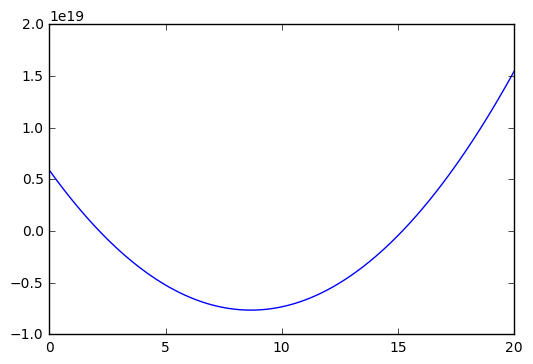

In [236]:
idx = where(rp_raw<9.0)# (data_raw>0.001) &(data_raw<0.016)) # &
print len(idx[0])
covjk = 99.0*mat(cov(data_jk[:,idx[0]],rowvar=0))
covIjk = covjk.I

def chisq2d (Ai):
    dN = mat(Ai*xi_lowzbin[idx]-data_raw[idx])
    return float(dN*covIjk*dN.T)

Ai_arr = linspace(0, 20, 101)
chi_arr = map(chisq2d, Ai_arr)

plot(Ai_arr, chi_arr)
show()

In [200]:
print data_raw.shape, covjk.shape, data_flat.shape, rp_raw.shape

(500,) (500, 500) (500,) (500,)
